In [1]:
import cv2
import glob
import numpy as np
from IPython.display import Image

# Step (1): 
Load the images and camera intrinsic parameters. This is the same as task 1 step (1). The only difference is that in this task an image pair is used. You can calibrate two views obtained from the two cameras in the stereo camera system, e.g., using the images "left_0.png" and "right_0.png", or you can calibrate two views obtained from one camera at two different poses, e.g., using the images "left_0.png" and "left_1.png". You also need to load the camera intrinsic parameters obtained in task 1.

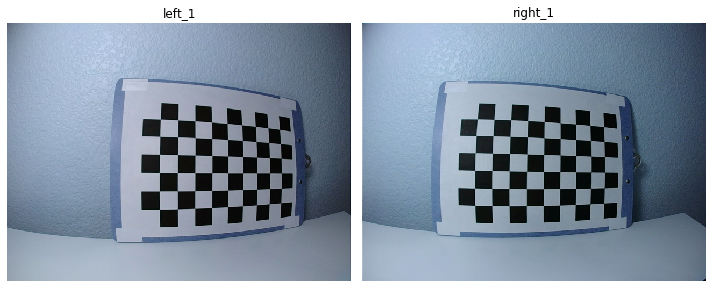

In [2]:
left_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/task_2/left_*.png"))]
right_ = [cv2.imread(image) for image in sorted(glob.glob("../../images/task_2/right_*.png"))]

import matplotlib.pyplot as plt
def plot_figures(figures, nrows=1, ncols=1):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    if(nrows > 1 or ncols > 1):
        for ind,title in enumerate(figures):
            axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
            axeslist.ravel()[ind].set_title(title)
            axeslist.ravel()[ind].set_axis_off()
        plt.tight_layout() # optional
    else:
        for ind,title in enumerate(figures):
            axeslist.imshow(figures[title], cmap=plt.gray())
            axeslist.set_title(title)
            axeslist.set_axis_off()
            

plot_figures({'left_1': left_[0], 'right_1': right_[0]}, 1, 2)

In [3]:
s = cv2.FileStorage('../task_1/calibrated_camera_parameters.xml', cv2.FileStorage_READ)

mtx_left = s.getNode('mtx_left').mat()
distCoeffs_left = s.getNode('distCoeffs_left').mat()

mtx_right = s.getNode('mtx_right').mat()
distCoeffs_right = s.getNode('distCoeffs_right').mat()

# Step (2): Extract 3D-to-2D point correspondences :

This is the same as task 1 step (2). The only difference is that in this task there are two sets of 2D points for both cameras. The 3D points are the same as those in task 1 step (2).


In [4]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

rows = 6
columns = 9

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(columns,5,0)
objp = np.zeros((columns*rows,3), np.float32)
objp[:,:2] = np.mgrid[0:columns,0:rows].T.reshape(-1,2)
# objp = objp*25.4   # only use when using the images from Duo

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space

In [5]:
imgpoints_left = [] # 2d points in image plane.

for img_og in left_:
    img = img_og.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (columns,rows),None)
    print(ret,end=' ')
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)   # this does not do anything
        imgpoints_left.append(corners2)

True True 

In [6]:
imgpoints_right = [] # 2d points in image plane.

for img_og in right_:
    img = img_og.copy()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (columns,rows),None)
    print(ret,end=' ')
    
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)   # this does not do anything
        imgpoints_right.append(corners2)

True True 

# Step (3): Calibrate the stereo camera :
Once the 3D-to-2D point correspondences are obtained, call OpenCV library function "stereoCalibrate()" to calculate the parameters between the two views, including the translation, rotation, the fundamental matrix, and the essential matrix. Note that the "CALIB_FIX_INTRINSIC" flag should be set and the camera intrinsics should be provided when you call the stereo calibration library function.

## calibrateCamera():

C++: double calibrateCamera(InputArrayOfArrays objectPoints, InputArrayOfArrays imagePoints, Size imageSize, InputOutputArray cameraMatrix, InputOutputArray distCoeffs, OutputArrayOfArrays rvecs, OutputArrayOfArrays tvecs, int flags=0, TermCriteria criteria=TermCriteria( TermCriteria::COUNT+TermCriteria::EPS, 30, DBL_EPSILON) )

Python: cv2.calibrateCamera(objectPoints, imagePoints, imageSize[, cameraMatrix[, distCoeffs[, rvecs[, tvecs[, flags[, criteria]]]]]]) → retval, cameraMatrix, distCoeffs, rvecs, tvecs¶

## stereoCalibrate():

C++: double stereoCalibrate(InputArrayOfArrays objectPoints, InputArrayOfArrays imagePoints1, InputArrayOfArrays imagePoints2, InputOutputArray cameraMatrix1, InputOutputArray distCoeffs1, InputOutputArray cameraMatrix2, InputOutputArray distCoeffs2, Size imageSize, OutputArray R, OutputArray T, OutputArray E, OutputArray F, TermCriteria criteria=TermCriteria(TermCriteria::COUNT+TermCriteria::EPS, 30, 1e-6), int flags=CALIB_FIX_INTRINSIC )

Python: cv2.stereoCalibrate(objectPoints, imagePoints1, imagePoints2, imageSize[, cameraMatrix1[, distCoeffs1[, cameraMatrix2[, distCoeffs2[, R[, T[, E[, F[, criteria[, flags]]]]]]]]]]) → retval, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F

In [7]:
stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)

flag = 0
flag |= cv2.CALIB_FIX_INTRINSIC

ret, M1, d1, M2, d2, R, T, E, F = cv2.stereoCalibrate(
                            objectPoints= objpoints, 
                           imagePoints1 = imgpoints_left, 
                           imagePoints2 = imgpoints_right, 
                           imageSize = tuple([640, 480]), 
                           cameraMatrix1 =mtx_left,
                           distCoeffs1 = distCoeffs_left,
                           cameraMatrix2 = mtx_right,
                           distCoeffs2 = distCoeffs_right,
                           criteria = stereocalib_criteria,
                           flags = flag 
                          )


print ("ret: ",ret)
print ("M1:\n",M1)

ret:  1.2005711200053568
M1:
 [[536.07343019   0.         342.37038789]
 [  0.         536.01634475 235.53685636]
 [  0.           0.           1.        ]]


In [8]:
np.array_equal(M1, mtx_left)

True

In [9]:
print(R, T, E, F)

[[ 0.99551048  0.00310833  0.09460035]
 [-0.00137416  0.99982992 -0.01839119]
 [-0.09464143  0.01817862  0.99534544]] [[-3.41534983]
 [-0.13762758]
 [ 0.51689313]] [[ 0.01373557 -0.5193071  -0.1274807 ]
 [ 0.19133893  0.06369303  3.44835114]
 [ 0.14170294 -3.41434116  0.07583195]] [[-6.40342866e-07  2.42123275e-05 -2.29774184e-03]
 [-8.93227610e-06 -2.97369867e-06 -8.25382104e-02]
 [-1.16680606e-03  7.91229834e-02  1.00000000e+00]]


In [10]:
T

array([[-3.41534983],
       [-0.13762758],
       [ 0.51689313]])

# Step (4): Check results by plotting in 3D
After these parameters are obtained, you can write a program to plot the camera position in 3D, like those in Figure 5. The calibration board pattern is also shown in 3D space, where the 3D points are obtained by triangulation using OpenCV library function "triangulatePoints()". Note that triangulation requires undistorted points, which can be obtained by OpenCV library function "undistortPoints()" to undistort. Note that your calibration results are in the unit of calibration cell width if you did not use actual scales of the board in meter or millimeter. You can recover the scale using the baseline length, i.e., scale the calculated translation vector "t" such that its Euclidean norm is the baseline length.
https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#triangulatepoints


Python: cv2.triangulatePoints(projMatr1, projMatr2, projPoints1, projPoints2[, points4D]) → points4D

Python: cv2.undistortPoints(src, cameraMatrix, distCoeffs[, dst[, R[, P]]]) → dst


### undistortPoints

In [11]:
undistortedPoints_left = []
for imgpoints in imgpoints_left:
    undistortedPoints_left.append(cv2.undistortPoints(imgpoints, M1, d1, None, None, None))

undistortedPoints_right = []
for imgpoints in imgpoints_right:
    undistortedPoints_right.append(cv2.undistortPoints(imgpoints, M2, d2, None, None, None))

In [12]:
undistortedPoints_right[0].shape

(54, 1, 2)

### triangulatePoints

In [13]:
points4D = cv2.triangulatePoints(projMatr1=,
                                 projMatr2=,
                                 projPoints1=undistortedPoints_left[0], 
                                 projPoints2=undistortedPoints_right[0], 
                                 points4D=None)


SyntaxError: invalid syntax (<ipython-input-13-547177158098>, line 1)

In [14]:
points4D.shape

NameError: name 'points4D' is not defined

In [15]:
x = points4D[0]/points4D[3]
y = points4D[1]/points4D[3]
z = points4D[2]/points4D[3]

NameError: name 'points4D' is not defined

NameError: name 'x' is not defined

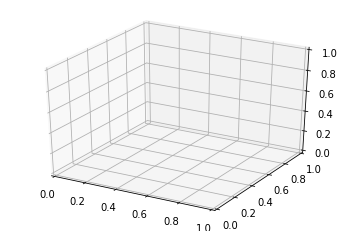

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x,y,z)
plt.show()

# Step (5): Rectify the stereo camera. 
Once the translation and rotation (R, t) are obtained, call OpenCV library function "stereoRectify()" to calculate parameters necessary for rectifying the two cameras. Note that the obtained rotation matrices R1 and R2 are rotations from the unrectified pose to the rectified pose. You can use them to show the camera pose. 

stereoRectify
Python: cv.StereoRectify(cameraMatrix1, cameraMatrix2, distCoeffs1, distCoeffs2, imageSize, R, T, R1, R2, P1, P2, Q=None, flags=CV_CALIB_ZERO_DISPARITY, alpha=-1, newImageSize=(0, 0)) -> (roi1, roi2)

In [17]:
R1,R2,P1,P2,Q,roi1,roi2 = cv2.stereoRectify(cameraMatrix1=mtx_left, 
                        cameraMatrix2=mtx_right, 
                        distCoeffs1=distCoeffs_left,
                        distCoeffs2=distCoeffs_right,
                        imageSize=(480,640),
                        R=R,
                        T=T)

In [18]:
R1

array([[ 0.99761743,  0.0401575 , -0.05609661],
       [-0.0408396 ,  0.99910444, -0.01106584],
       [ 0.055602  ,  0.01333044,  0.99836402]])

In [19]:
T

array([[-3.41534983],
       [-0.13762758],
       [ 0.51689313]])

# Step (6): Check the rectification results. 
After these parameters are obtained, you can undistort images by providing the rectification parameters, and show the rectified images like those in Figure 6. It can be observed that the calibration board points are in row correspondences, i.e., the projected 2D points of the same 3D points have the same y-axis coordinates in the two rectified images. This is essentially the same as task 1 step (4) but in this task you need to provide the rectification parameters to the OpenCV library function "initUndistortRectifyMap()". You can also write a program to plot the camera position in 3D, like those in Figure 7. This example uses two views obtained from one camera at two different poses, i.e., the images "left_0.png" and "left_1.png". Note in this example two images taken by the left camera at two different poses are rectified, instead of using a pair of images taken by the left camera and the the right camera at the same time. If you choose to use the two views obtained from the left camera and the right camera, the rectification results are not significant since they are already in good alignment. 

#### undistort and rectify

In [31]:
# left image
h, w = left_[0].shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_left, distCoeffs_left, (w,h), 1, (w,h))
x,y,w,h = roi
left_0_undistorted = cv2.undistort(left_[0].copy(), mtx_left, distCoeffs_left, None, newcameramtx)[y:y+h, x:x+w]

mapx,mapy = cv2.initUndistortRectifyMap(mtx_left,distCoeffs_left,R1,newcameramtx,(w,h),5)
left_0_rectified = cv2.remap(left_[0].copy(),mapx,mapy,cv2.INTER_LINEAR)[y:y+h, x:x+w]

# right image
h, w = right_[0].shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx_right, distCoeffs_right, (w,h), 1, (w,h))
x,y,w,h = roi
right_0_undistorted = cv2.undistort(right_[0].copy(), mtx_right, distCoeffs_right, None, newcameramtx)[y:y+h, x:x+w]

mapx,mapy = cv2.initUndistortRectifyMap(mtx_right,distCoeffs_right,R2,newcameramtx,(w,h),5)
right_0_rectified = cv2.remap(right_[0].copy(),mapx,mapy,cv2.INTER_LINEAR)[y:y+h, x:x+w]

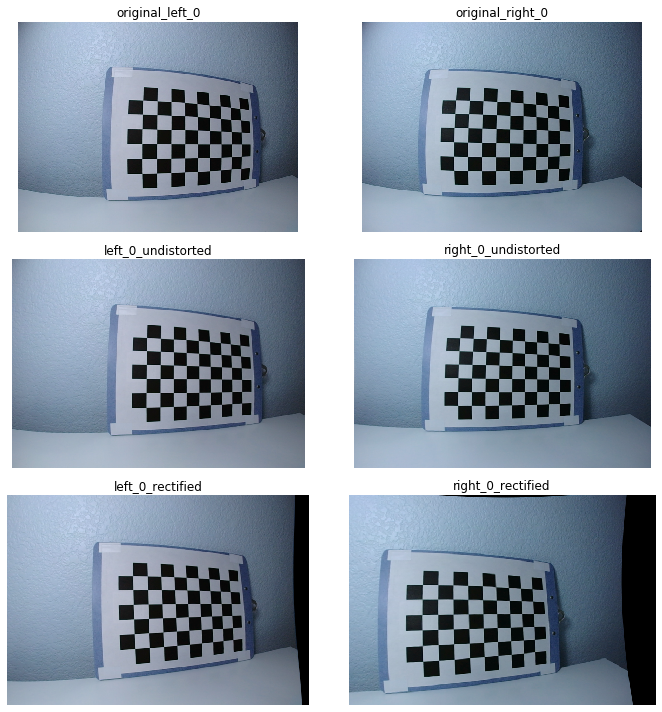

In [32]:
plot_figures({'original_left_0':left_[0], 'original_right_0':right_[0],
             'left_0_undistorted':left_0_undistorted, 'right_0_undistorted':right_0_undistorted,
             'left_0_rectified':left_0_rectified, 'right_0_rectified':right_0_rectified},3,2)

In [26]:
left_[0].shape, left_0_undistorted.shape, left_0_rectified.shape

((480, 640, 3), (448, 625, 3), (431, 621, 3))

# Step (7): Save the parameters to a file. 
Same as Task 1 step (5). These parameters should be saved for future use.

In [34]:
s = cv2.FileStorage('../../parameters/stereo_rectification.xml', cv2.FileStorage_WRITE)

s.write('R', R)
s.write('T', T)
s.write('E', E)
s.write('F', F)

s.write('R1', R1)
s.write('R2', R2)
s.write('P1', P1)
s.write('P2', P2)
s.write('Q', Q)
s.write('roi1', roi1)
s.write('roi2', roi2)

s.release()